In [1]:
import mastermat

First, you would make the master matrix by making a meta-manager which knows about the location of each PSF, and then using these locations in combination with the PSFs to do a singular value decomposition thereof. Normalizing the results of the singular value decomposition, you would get a matrix of kernels and a matrix of weights, which, when multiplied together, should give a matrix whose columns can be shifted up and down to make the final mastermat.

Do not uncomment the code below unless you know what you're doing. I'm leaving it here for a record of how stuff used to be done, which may help decipher some code that is no longer used.

In [2]:
# row_inds_csr, col_inds_csr, values_csr, row_inds, col_inds, values = mastermat.load_memmaps((800,1280))

In [3]:
# row_ins_csr, col_inds_csr, values_csr = mastermat.compute_csr(row_inds, col_inds, values)

In [4]:
# import numpy as np
# np.save("row_inds_csr.npy", row_inds_csr)
# np.save("col_inds_csr.npy", col_inds_csr)
# np.save("values_csr.npy", values_csr) 

The cell below is of UTMOST importance. Add a new definition of `savepath` to match what you put in `make_mastermat.py`. The first entry is the path to the array of row indices, the second entry is the path to the array of column indices, the third entry is the path to the array of nonzero values.

In [5]:
# ignore the stuff below; this is all commented out and left over from before
# savepath = ("row_inds_probe_green_undistorted_csr.npy", "col_inds_probe_green_undistorted_csr.npy", "values_probe_green_undistorted_csr.npy")


# EDIT ME: comment out the line below.
savepath = ("../data/mastermat/row_inds_ringed_curved.npy", "../data/mastermat/col_inds_ringed_curved.npy","../data/mastermat/values_ringed_curved.npy")

After making the change described above, the rest of the notebook should run fine.

In [6]:
row_inds_csr, col_inds_csr, values_csr = mastermat.load_csr_files(csr_paths=savepath)

In [7]:
values_csr.shape

(1083334020,)

In [8]:
row_inds_csr.shape

(1023771,)

In [9]:
import matplotlib as mpl
# mpl.rc('image', cmap='inferno')
mpl.rc('image', cmap='viridis')

In [10]:
import numpy as np

row_inds_csr_expanded = np.empty(1024001)
row_inds_csr_expanded[:row_inds_csr.shape[0]] = row_inds_csr
row_inds_csr_expanded[row_inds_csr.shape[0]:] = row_inds_csr[-1]

In [11]:
import scipy
mastermat_csr = scipy.sparse.csr_matrix((values_csr, col_inds_csr, row_inds_csr_expanded), shape=(1024000, 1024000))

In [12]:
mastermat_csr.shape

(1024000, 1024000)

In [13]:
np.max(mastermat_csr.data)

0.3706604852345994

In [14]:
mastermat_csr.getnnz()

1083334020

We're now trying to test this mastermat. To do this, make an appropriately-sized vector of ones, then matrix-multiply it with mastermat

In [15]:
onesvec = np.ones(mastermat_csr.shape[1])

In [16]:
ones_sim = mastermat_csr.dot(onesvec)

In [17]:
mastermat_csr.indptr[83]

0

In [18]:
np.bincount(mastermat_csr.indptr)

array([234,   0,   1, ...,   0,   1, 231])

In [19]:
np.arange(mastermat_csr.shape[0])[ones_sim > 0]

array([    233,     234,     235, ..., 1023767, 1023768, 1023769])

In [20]:
ones_sim.reshape((800,1280))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
big_inds = np.arange(ones_sim.shape[0])[ones_sim > 10]

In [22]:
import imageio
import cv2

In [23]:
img_resized = imageio.imread("../data/nV3_resized/1.png")

/tmp/ipykernel_150113/2906533047.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_resized = imageio.imread("../data/nV3_resized/1.png")


In [24]:
img_resized.shape

(800, 1280)

In [25]:
mastermat_csr.shape

(1024000, 1024000)

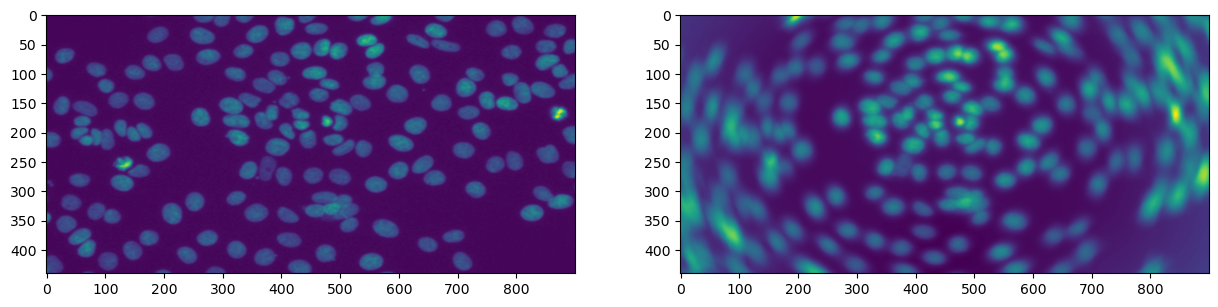

In [26]:
from matplotlib import pyplot as plt
import pdb
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(img_resized[200:640,200:1100])
axs[1].imshow(mastermat.simulate_image(img_resized, mastermat_csr)[200:640,200:1100])

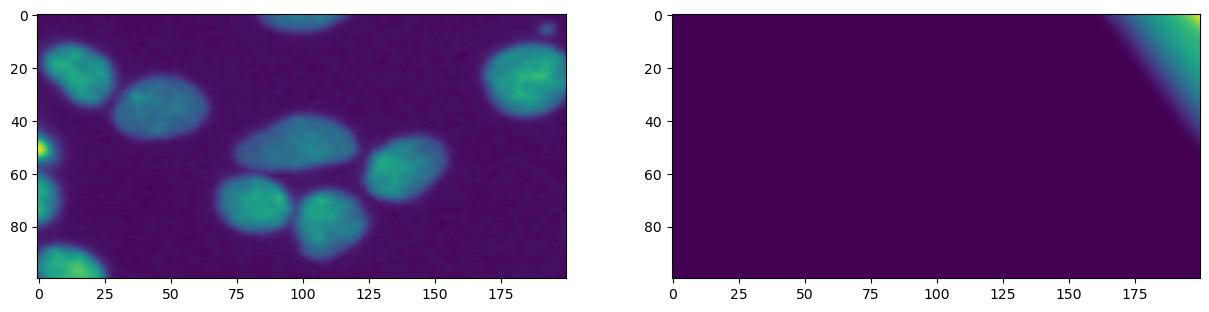

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(img_resized[700:,:200])
axs[1].imshow(mastermat.simulate_image(img_resized, mastermat_csr)[700:,:200])

In [28]:
%time
simmed_img = mastermat.simulate_image(img_resized, mastermat_csr)
# simmed_img[simmed_img > 50] = 0

CPU times: user 11 µs, sys: 20 µs, total: 31 µs
Wall time: 66.3 µs


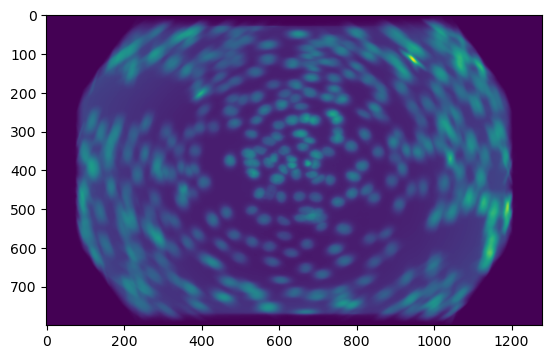

In [29]:
plt.imshow(simmed_img)

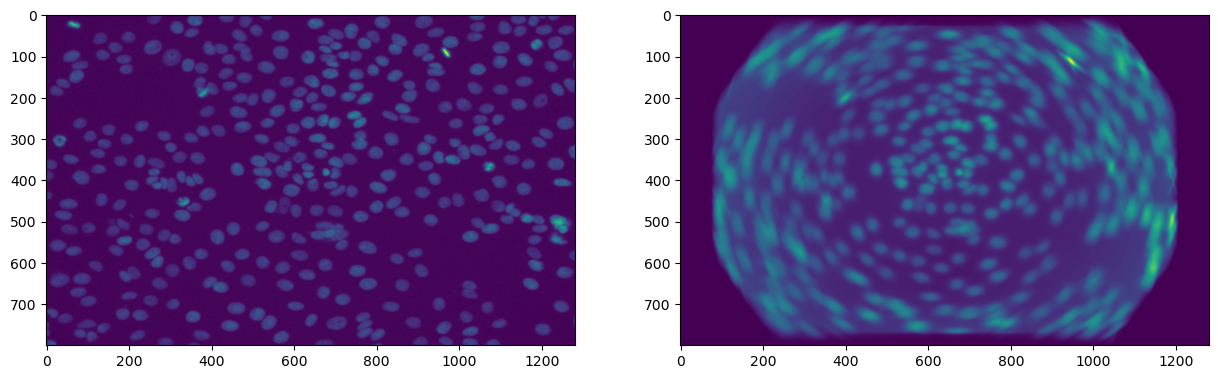

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(img_resized)
axs[1].imshow(simmed_img)

In [31]:
np.max(img_resized)

248

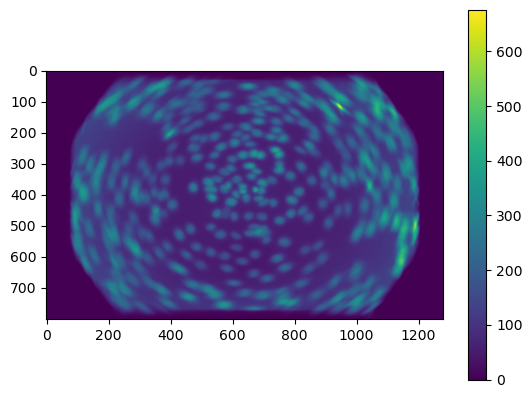

In [32]:
plt.imshow(simmed_img)
plt.colorbar()

In [33]:
np.arange(ones_sim.shape[0])[ones_sim > 10]

array([ 55272,  55273,  55274, ..., 964889, 964890, 964891])

In [34]:
ones_sim

array([0., 0., 0., ..., 0., 0., 0.])

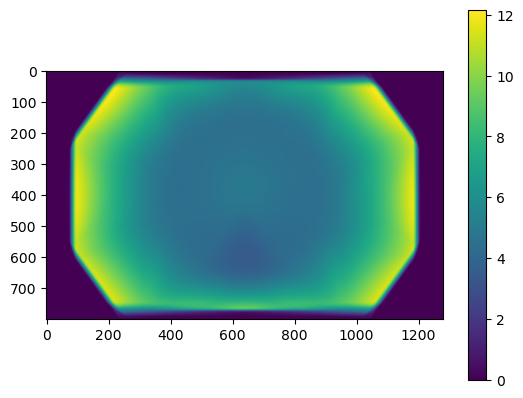

In [35]:
plt.imshow(mastermat.simulate_image(np.ones((800,1280)), mastermat_csr))
plt.colorbar()

In [36]:
mastermat_csr.indptr[200*1280 + 200 + 1] - mastermat_csr.indptr[200*1280 + 200]

1530

Above shows that 47 pixels contribute to the value of the simulated image at pixel 40000, but in reality the value at that point is:

In [37]:
ones_sim[200*1280 + 200]

9.301019475278018

In [38]:
ones_sim[ones_sim > 0].shape

(855645,)

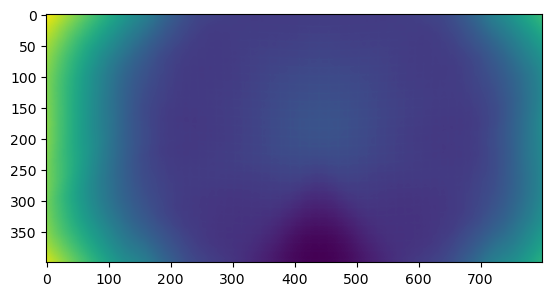

In [39]:
plt.imshow((ones_sim).reshape((800,1280))[200:600, 200:1000])

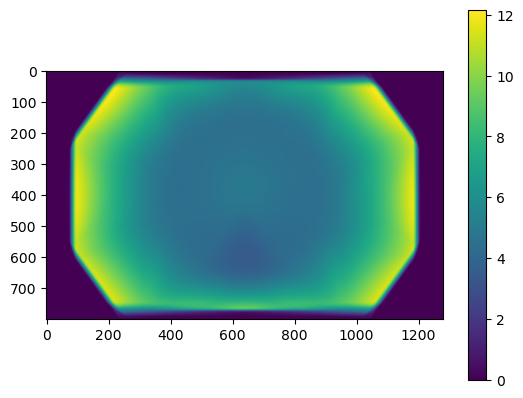

In [40]:
# plt.imshow((ones_sim*(ones_sim < 1)).reshape((800,1280)))
# plt.figure(figsize=(80,128))
plt.imshow((ones_sim).reshape((800,1280)))
plt.colorbar()

In [41]:
def um_to_px(x, um_size=640, pixel_size=800):
    return x*pixel_size/um_size

In [42]:
640/800 == 1024/1280

True

In [43]:
640/800

0.8

In [44]:
um_to_px(3)

3.75

In [45]:
def draw_circle(radius):
    canvas = np.zeros((2*np.ceil(radius).astype(int), 2*np.ceil(radius).astype(int)))
    Xq, Yq = np.meshgrid(np.arange(radius*2), np.arange(radius*2))
    rad_to_point = (Xq - radius)**2 + (Yq - radius)**2
    canvas = rad_to_point < radius**2
    return canvas

In [46]:
6*.8

4.800000000000001

In [47]:
def grid_of_circles(r, num_x, num_y, img_dims=(800,1280)):
    circle_obj = np.zeros(img_dims)
    for circ_row in range(1,num_y):
        for circ_col in range(1,num_x):
            circ_center = (circ_row*img_dims[0]//num_y, circ_col*img_dims[1]//num_x)
            circle_drawing = draw_circle(r)
            circle_obj[circ_center[0]-np.floor(circle_drawing.shape[0]/2).astype(int)\
                       :circ_center[0]+np.ceil(circle_drawing.shape[0]/2).astype(int), \
                       circ_center[1]-np.floor(circle_drawing.shape[1]/2).astype(int)\
                       :circ_center[1]+np.ceil(circle_drawing.shape[1]/2).astype(int)] = circle_drawing
    return circle_obj

In [48]:
img_dims = (800, 1280)
# circle_obj = np.zeros(img_dims)
r = 3


# pdb.set_trace()
num_x = 30
num_y = 30
# for circ_row in range(1,num_y):
#     for circ_col in range(1,num_x):
#         circ_center = (circ_row*img_dims[0]//num_y, circ_col*img_dims[1]//num_x)
#         circle_obj[circ_center[0]-r:circ_center[0]+r, circ_center[1]-r:circ_center[1]+r] = draw_circle(r)[:,:]

In [49]:
circle_obj = grid_of_circles(um_to_px(r), num_x, num_y, img_dims=(800,1280))

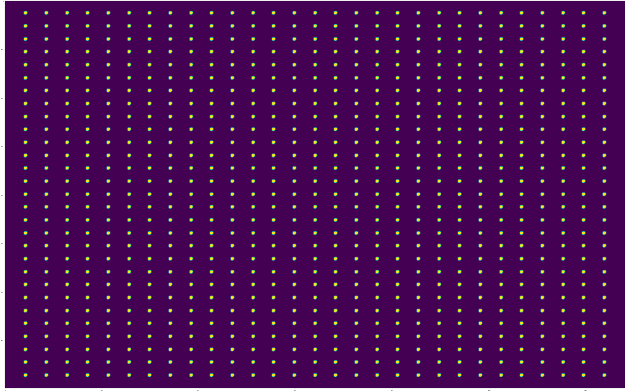

In [50]:
plt.figure(figsize=(80,128), dpi=10)
plt.imshow(circle_obj)

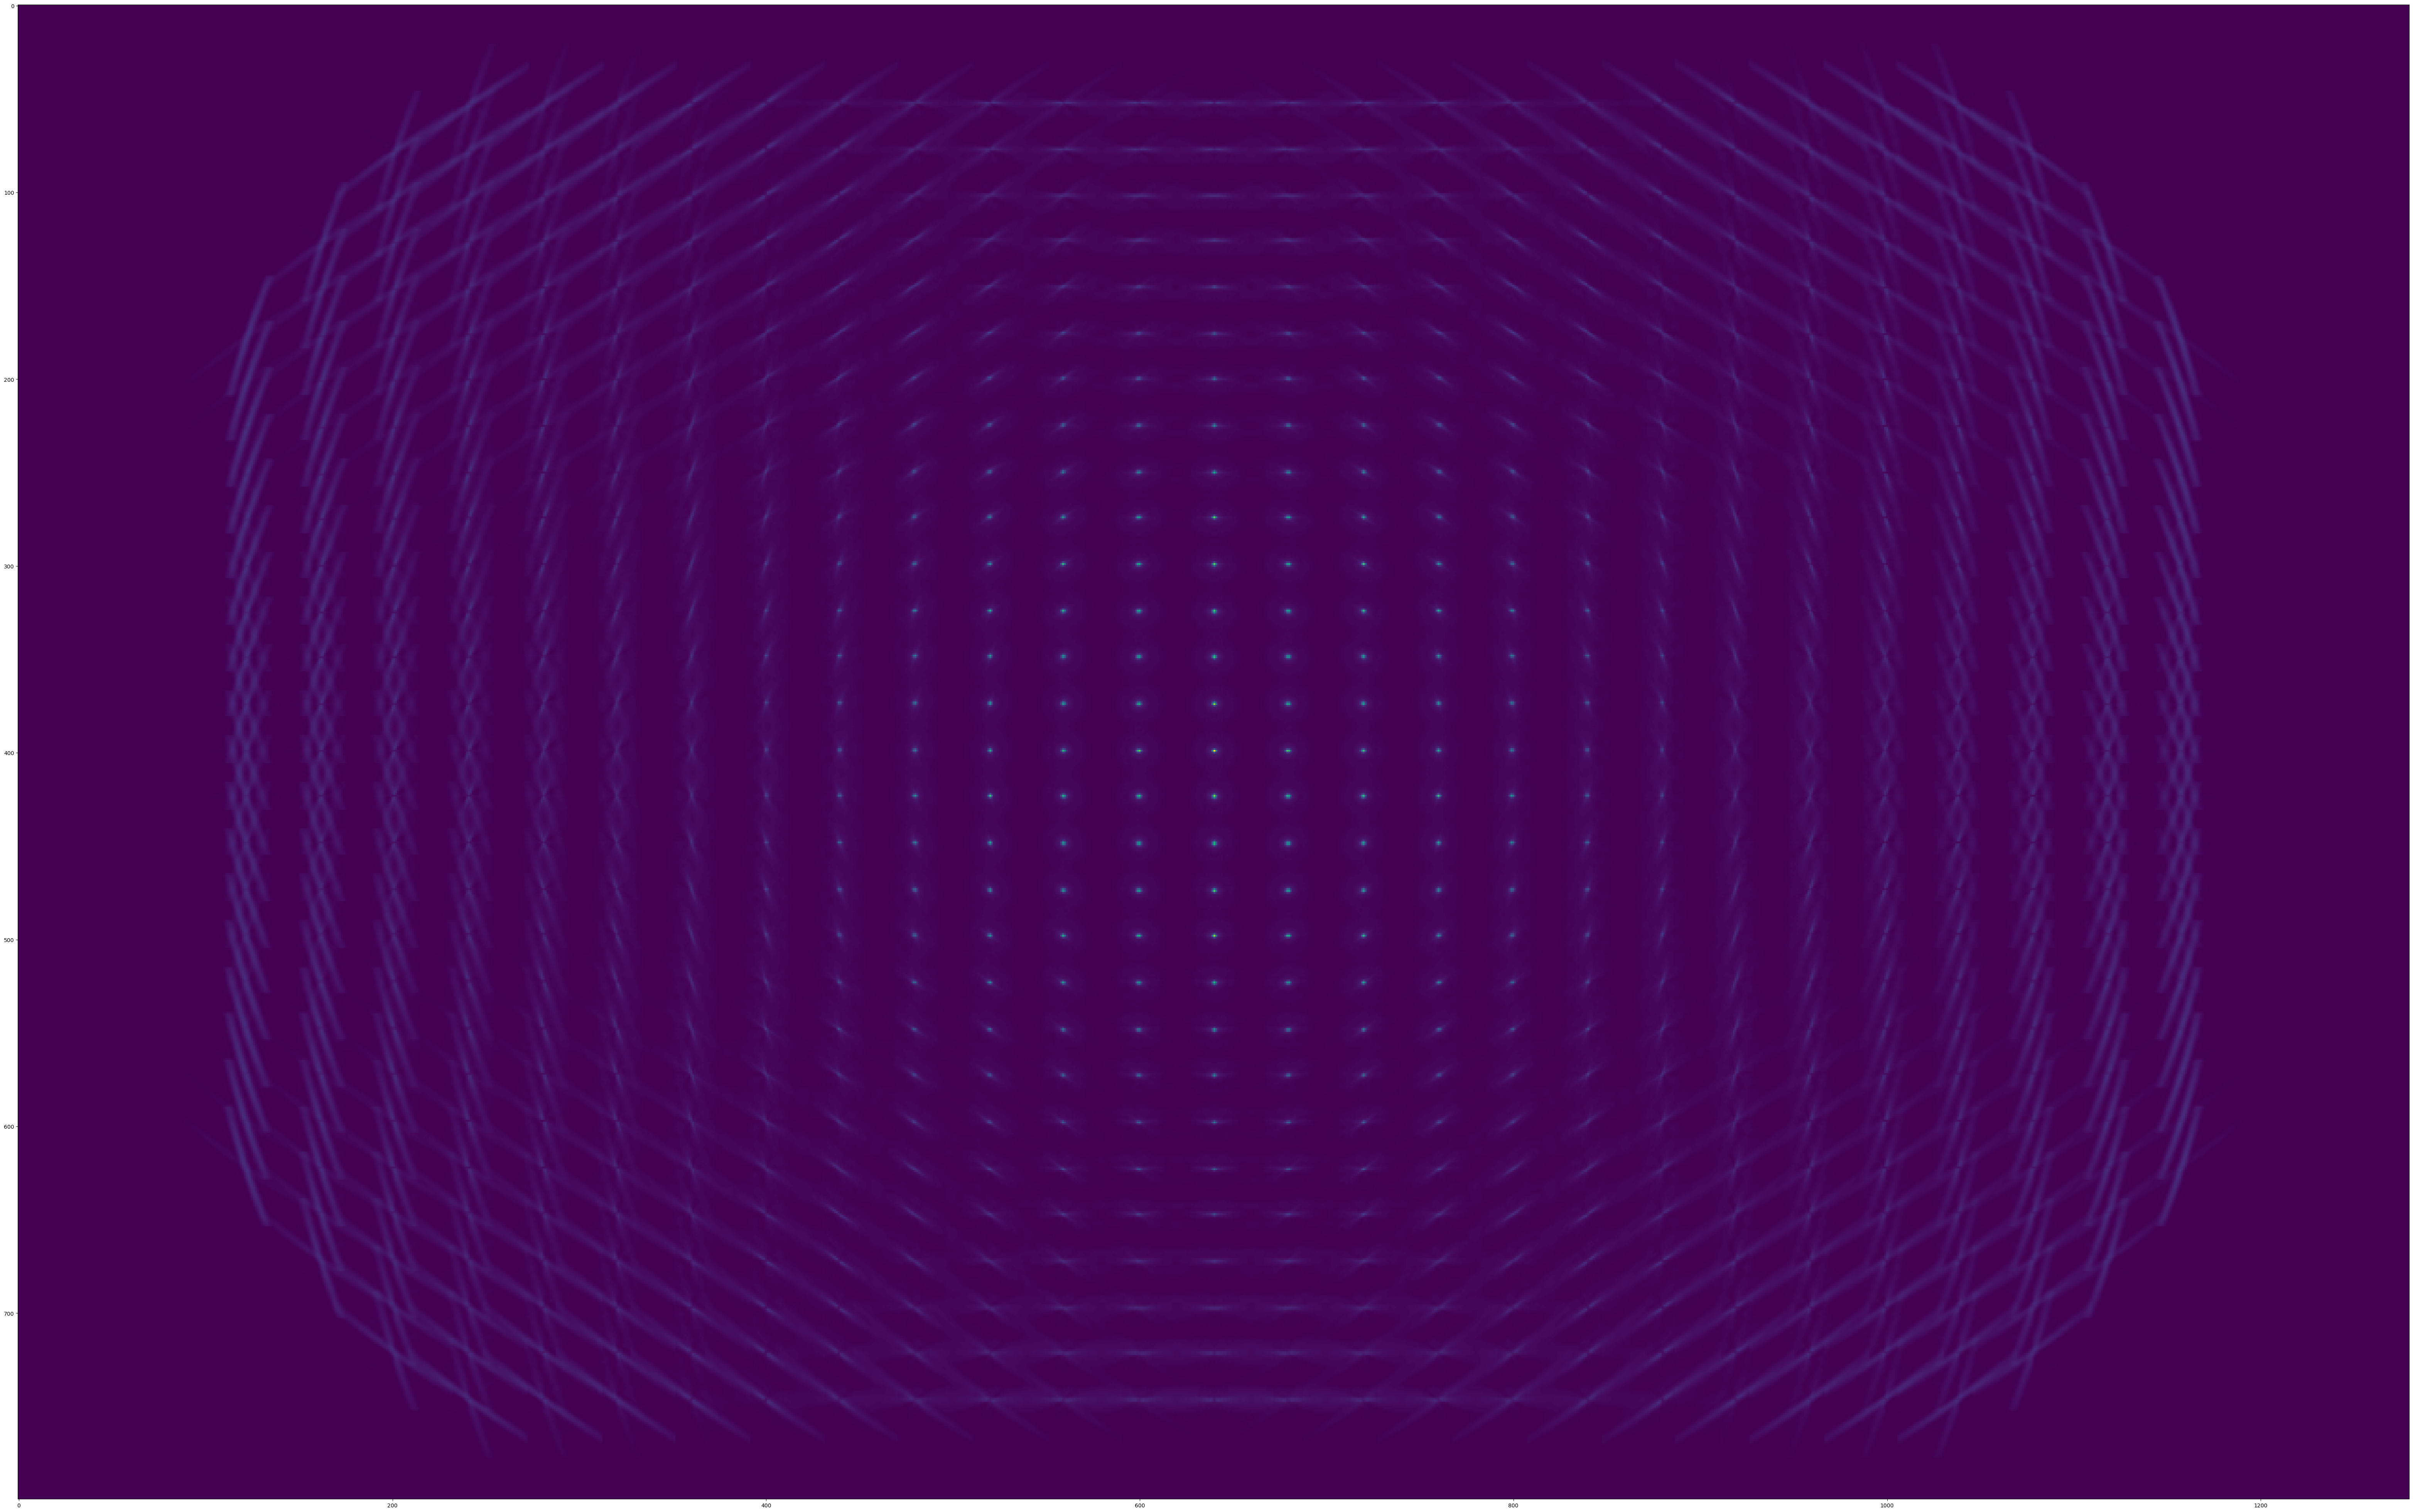

In [51]:
plt.figure(figsize=(80,128))
plt.imshow(mastermat.simulate_image(grid_of_circles(1, num_x, num_y, img_dims=(800,1280)), mastermat_csr))

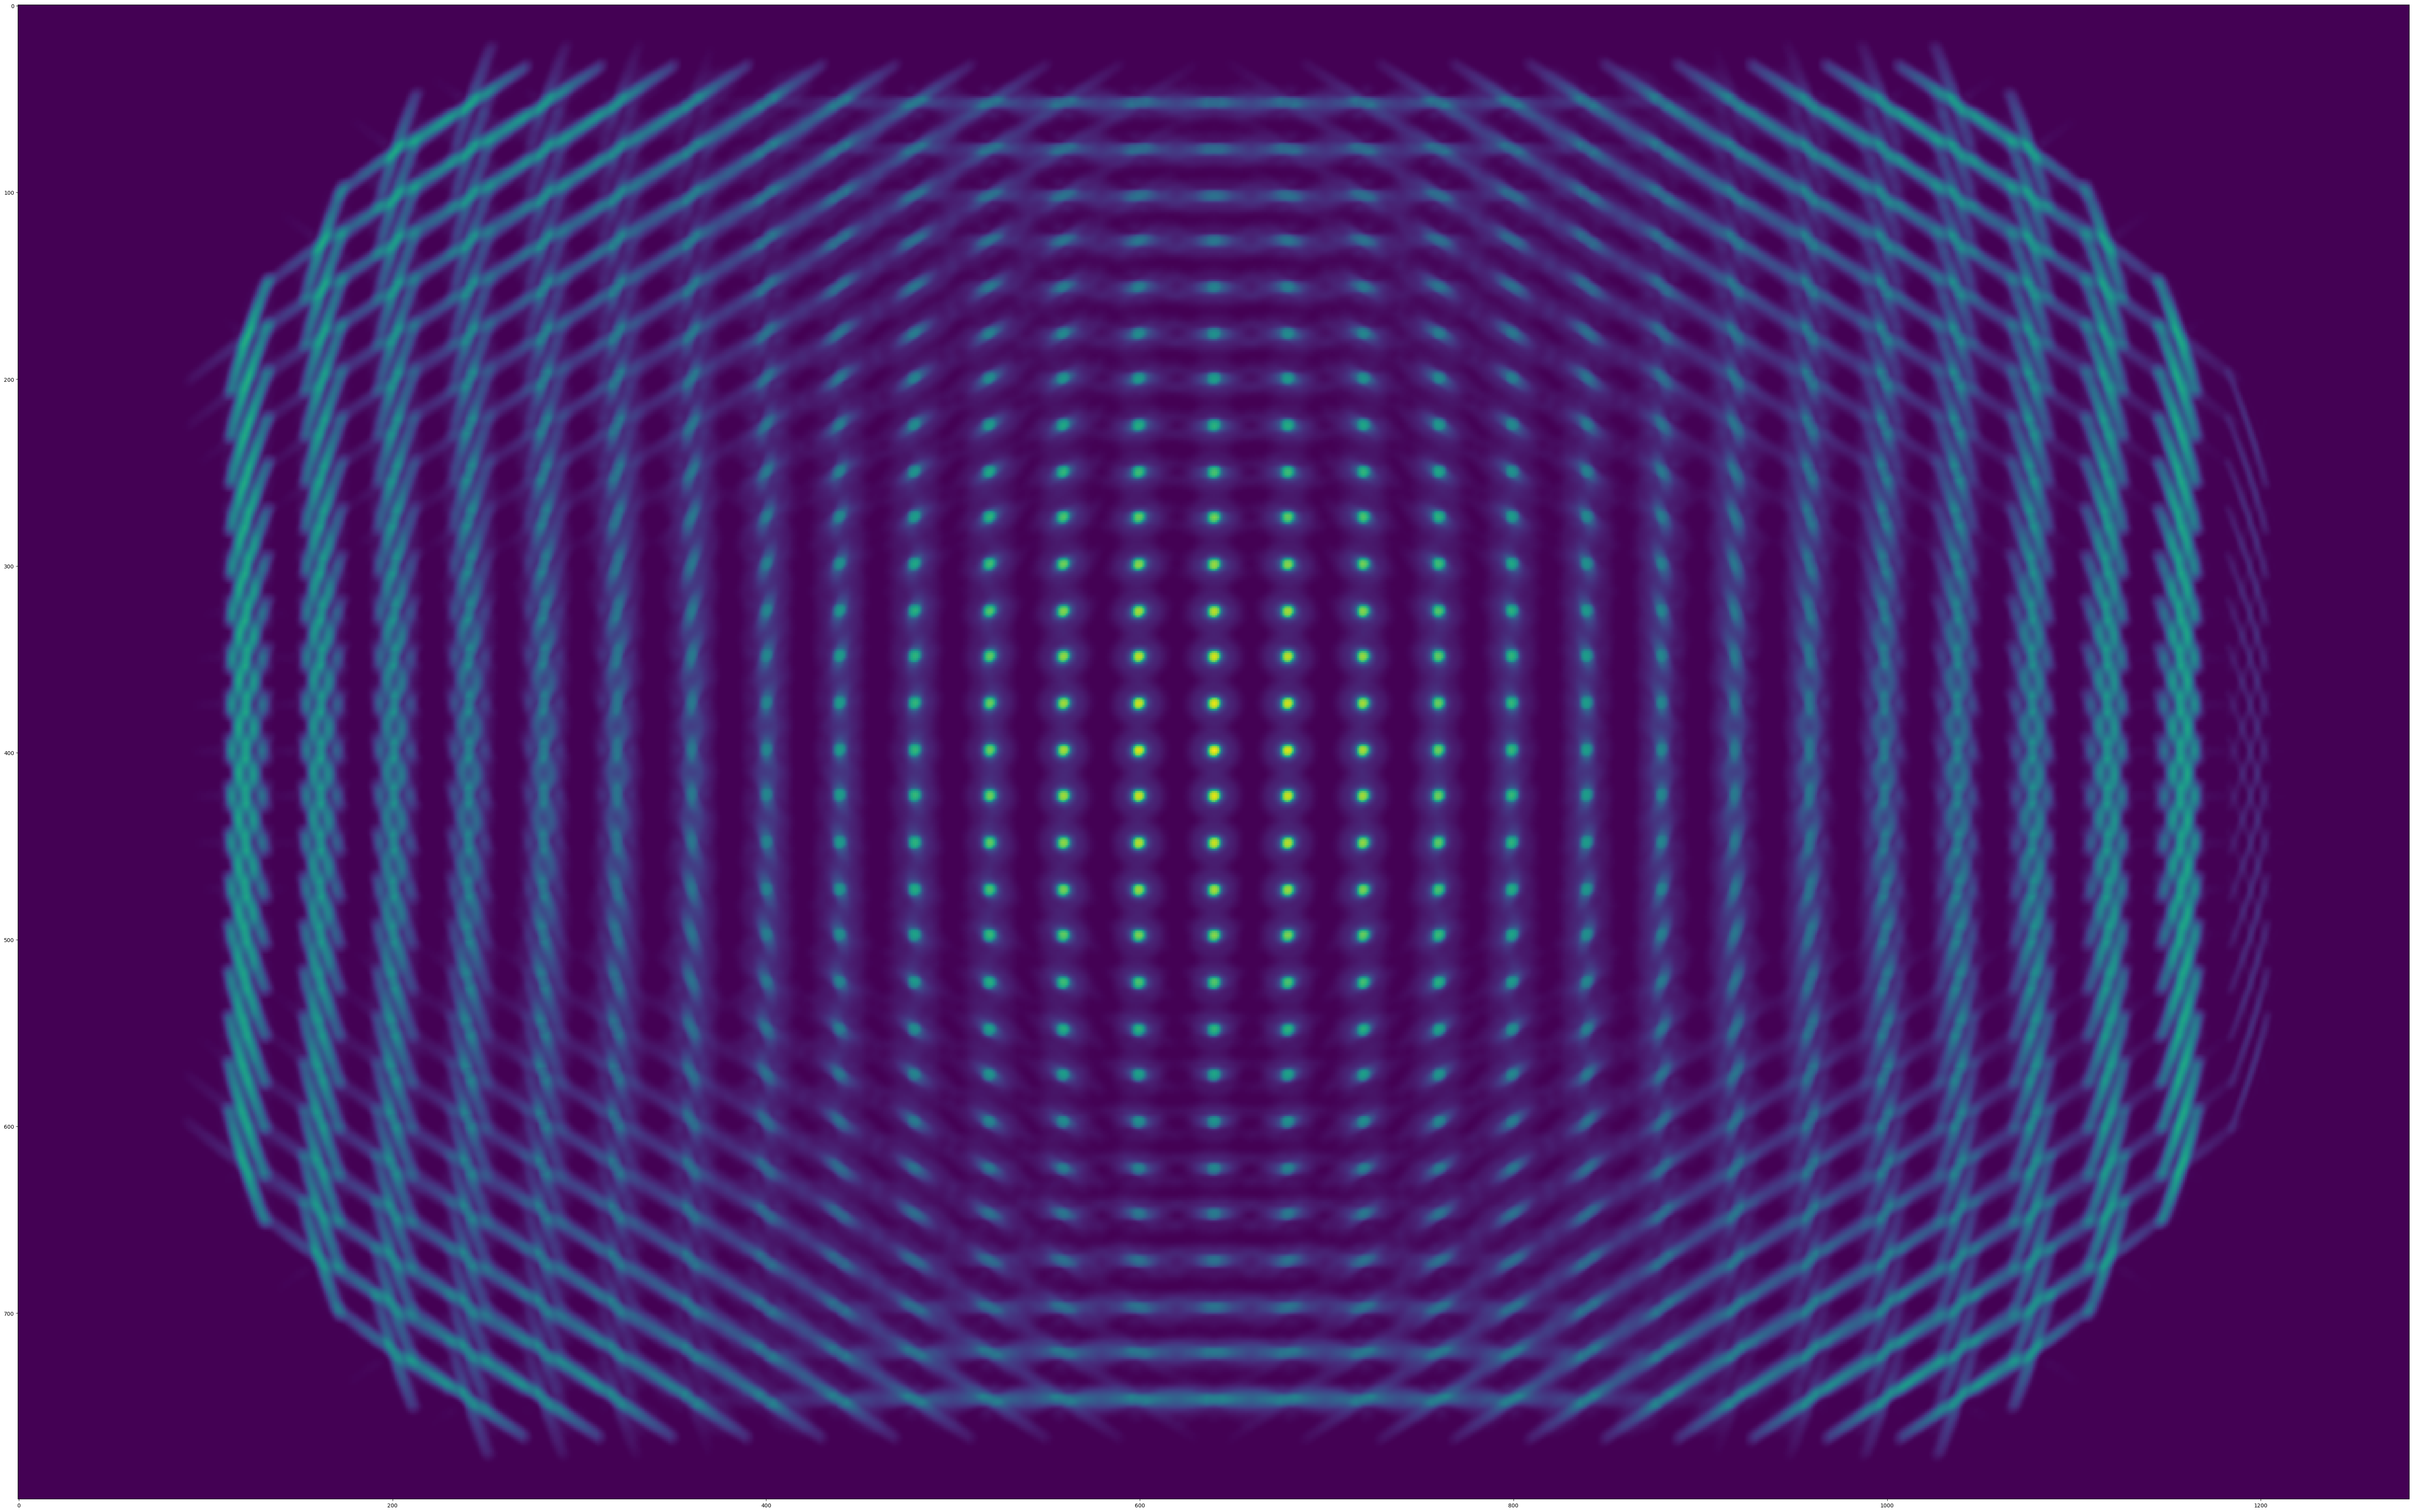

In [52]:
plt.figure(figsize=(80,128))
plt.imshow(mastermat.simulate_image(circle_obj, mastermat_csr))
# plt.colorbar()

## examining the locations of the sampled PSFs
I now want to just simulate an image with circles at the points where I am sampling my PSFs from (the origins of the fields).

In [53]:
import one_shot_svd
# this is the metafile for the curved object
# metaman = one_shot_svd.load_metaman("/home/dshteinbok/nV3_PSFs_flat_meta/metafile.csv")
metaman = one_shot_svd.load_metaman("../data/nV3_PSFs_flat_meta/metafile.csv")

In [54]:
# circle_drawing = draw_circle(5)
circle_drawing = draw_circle(um_to_px(3))

In [55]:
circle_drawing.shape

(8, 8)

In [56]:
blank_field = np.zeros((800,1280))
for origin in metaman.field_origins.values():
    location_px = [int(um_to_px(origin[1]))+400, int(um_to_px(origin[0]))+640]
#     print("In um: ", origin)
#     print("In px: ", location_px)
    if location_px[0] > 800 or location_px[1] > 1280 or location_px[0] < 0 or location_px[1] < 0:
#         print("skipping field!")
        continue
    blank_field[(location_px[0]-circle_drawing.shape[0]//2):(location_px[0]+circle_drawing.shape[0]//2), (location_px[1]-circle_drawing.shape[1]//2):(location_px[1]+circle_drawing.shape[1]//2)] = circle_drawing[:,:]

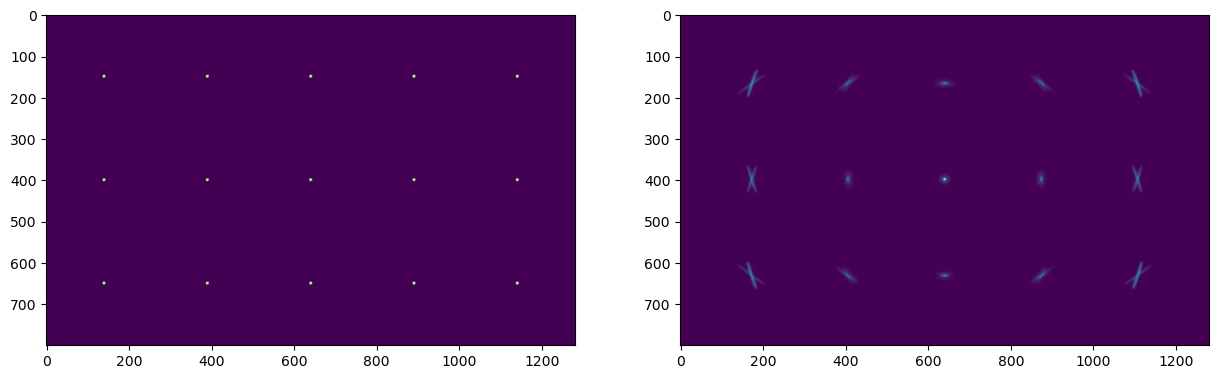

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(blank_field)
axs[1].imshow(mastermat.simulate_image(blank_field, mastermat_csr))

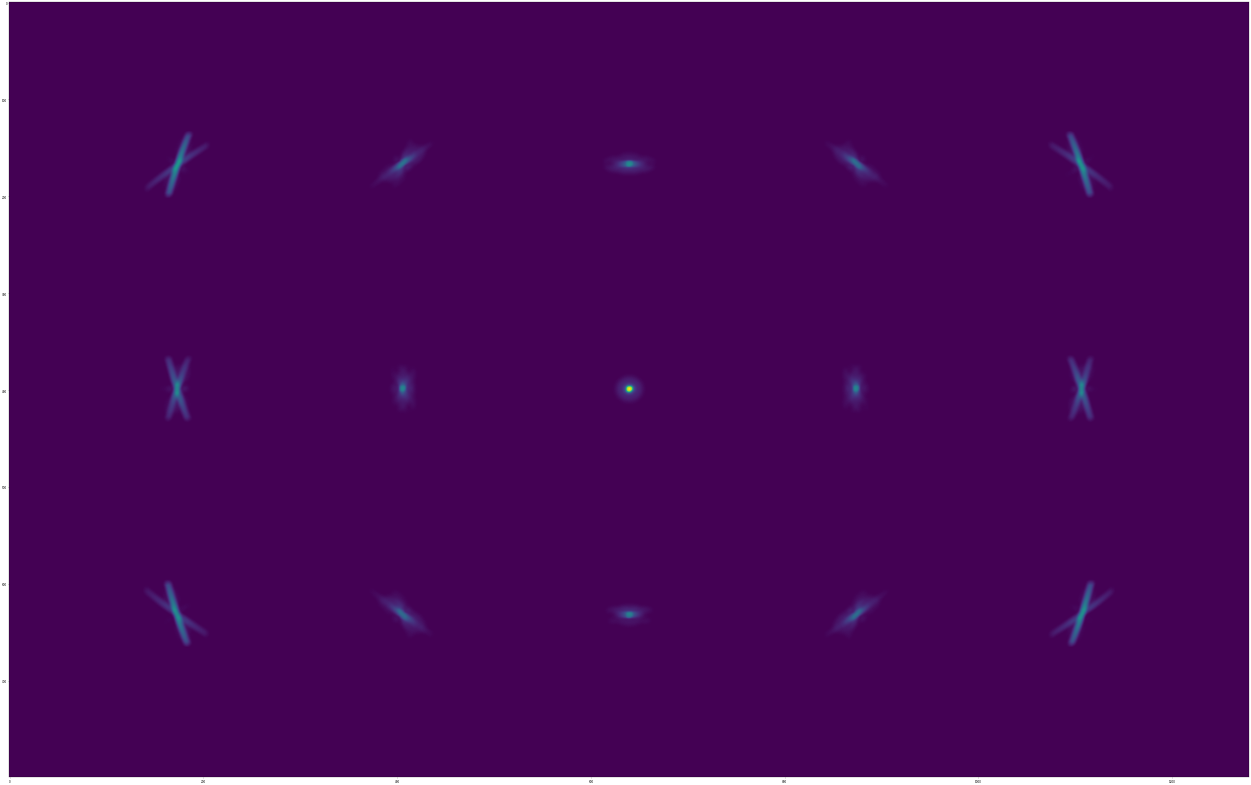

In [58]:
plt.figure(figsize=(80,128), dpi=20)
plt.imshow(mastermat.simulate_image(blank_field, mastermat_csr))

In [59]:
plt.figure?

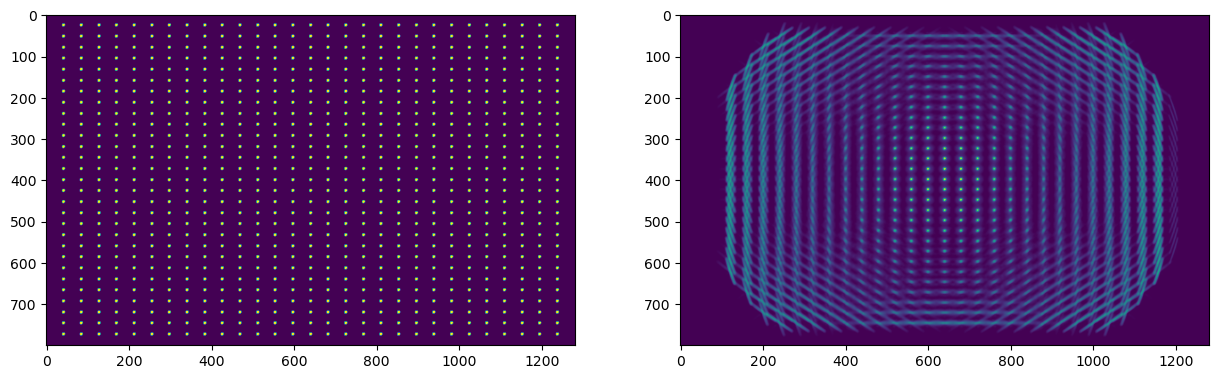

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(circle_obj)
axs[1].imshow(mastermat.simulate_image(circle_obj, mastermat_csr))

In [61]:
big_circle_obj = np.zeros((800, 1280))
r = 10

# pdb.set_trace()

for circ_row in range(1,10):
    for circ_col in range(1,10):
        circ_center = (circ_row*80, circ_col*128)
        big_circle_obj[circ_center[0]-r:circ_center[0]+r, circ_center[1]-r:circ_center[1]+r] = draw_circle(r)[:,:]

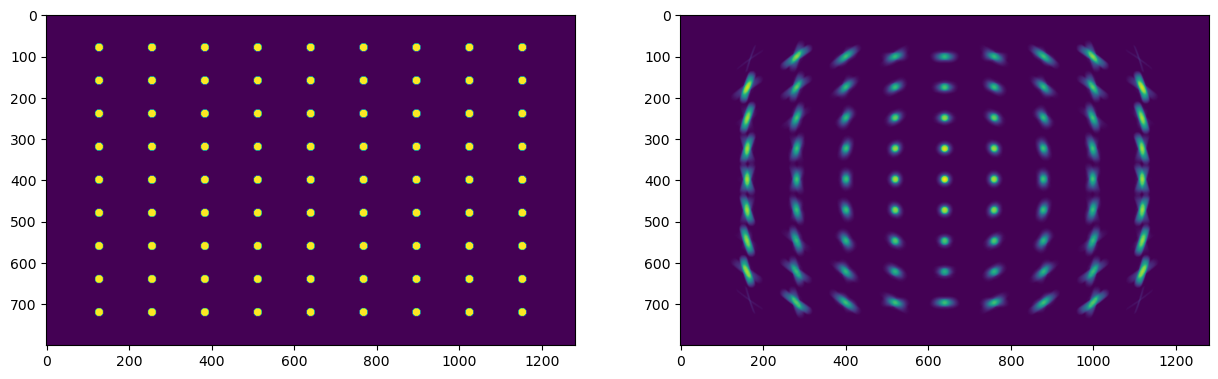

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(big_circle_obj)
axs[1].imshow(mastermat.simulate_image(big_circle_obj, mastermat_csr))

In [63]:
grid_img = np.zeros((800, 1280))

r = 2

# pdb.set_trace()

for line_row in range(80,800,80):
#     print("line row: ", line_row)
    grid_img[line_row-r:line_row + r,:] = 1
for line_col in range(128,1280,128):
    print("line col: ", line_col)
    grid_img[:,line_col-r:line_col+r] = 1
    pass

line col:  128
line col:  256
line col:  384
line col:  512
line col:  640
line col:  768
line col:  896
line col:  1024
line col:  1152


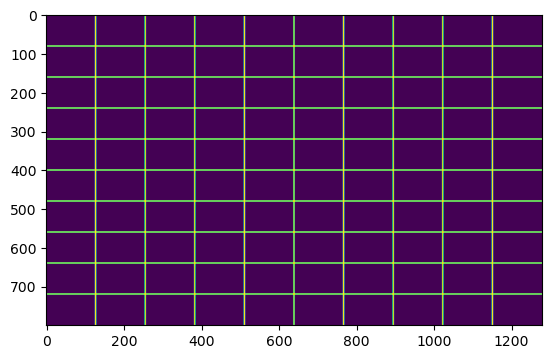

In [64]:
plt.imshow(grid_img)

In [65]:
range?

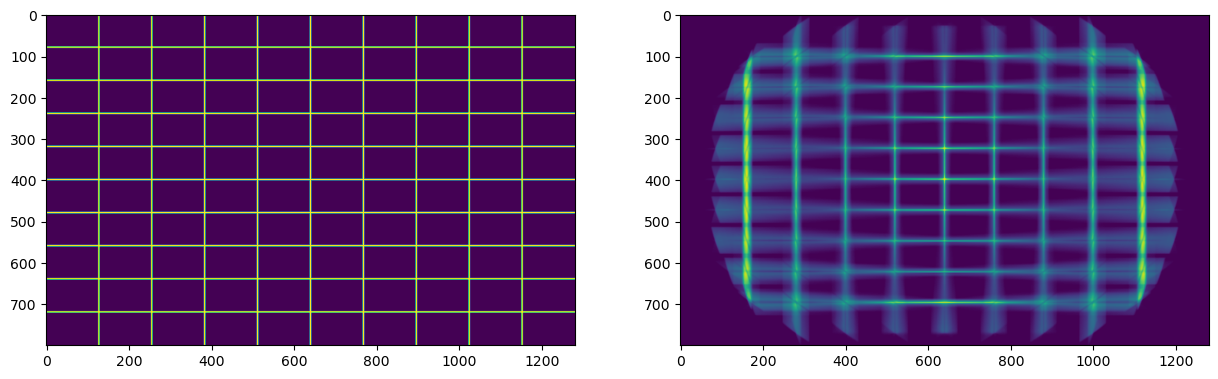

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(grid_img)
axs[1].imshow(mastermat.simulate_image(grid_img, mastermat_csr))

In [67]:
# savepath = ("row_inds_cub_csr.npy", "col_inds_cub_csr.npy", "values_cub_csr.npy")
savepath_lin = ("row_inds_lin_csr.npy", "col_inds_lin_csr.npy", "values_lin_csr.npy")
row_inds_lin_csr, col_inds_lin_csr, values_lin_csr = mastermat.load_csr_files(csr_paths=savepath_lin)

In [68]:
row_inds_csr_lin_expanded = np.empty(1024001)
row_inds_csr_lin_expanded[:row_inds_lin_csr.shape[0]] = row_inds_lin_csr
row_inds_csr_lin_expanded[row_inds_lin_csr.shape[0]:] = row_inds_lin_csr[-1]

In [69]:
mastermat_csr_lin = scipy.sparse.csr_matrix((values_lin_csr, col_inds_lin_csr, row_inds_csr_lin_expanded), shape=(1024000, 1024000))

In [70]:
# plt.imshow((mastermat_csr_lin.dot(onesvec) - mastermat_csr.dot(onesvec)).reshape((800,1280)))
# plt.colorbar()

In [71]:
f_img = np.zeros((800,1280))
fht = 5
fhh = 300
f_img[400-fhh:400+fhh,640-fht:640+fht] = 1
f_img[400-fhh:400-fhh+2*fht,640:1000] = 1
f_img[300-fht:300+fht,640:900] = 1

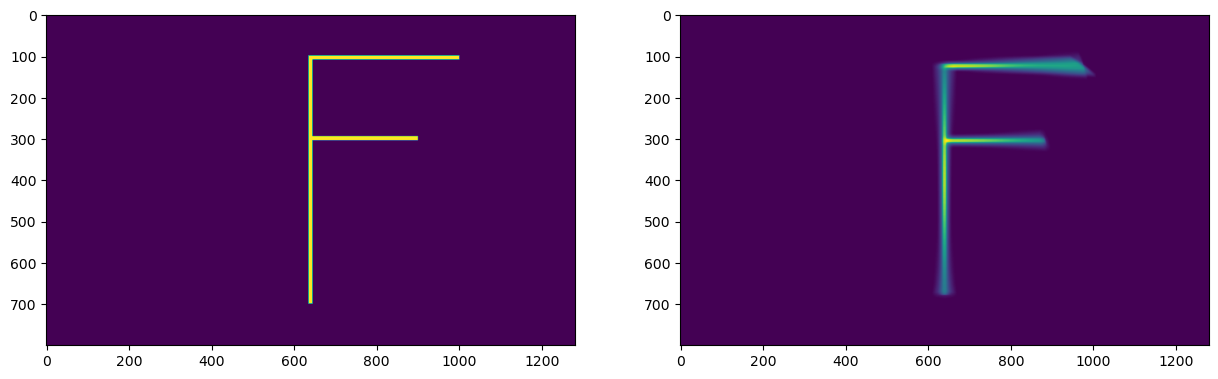

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(f_img)
axs[1].imshow(mastermat.simulate_image(f_img, mastermat_csr))

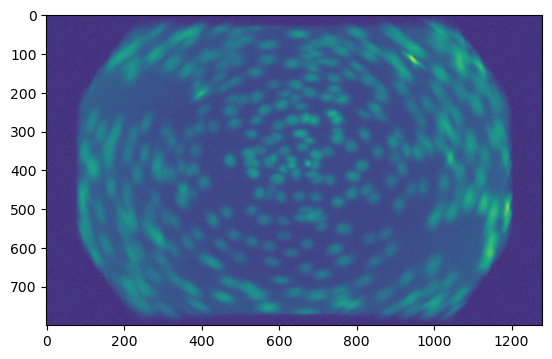

In [73]:
simmed_noisy = simmed_img + np.random.normal(0, 28, simmed_img.shape)
plt.imshow(simmed_noisy)

In [74]:
np.asarray(list(metaman.field_origins.values()))

array([[ 200.,    0.],
       [ 400.,    0.],
       [ 600.,    0.],
       [ 200., -200.],
       [ 400., -200.],
       [ 200., -400.],
       [ 400., -400.],
       [ 200.,  200.],
       [ 400.,  200.],
       [ 200.,  400.],
       [ 400.,  400.],
       [-200.,    0.],
       [-400.,    0.],
       [-600.,    0.],
       [-200., -200.],
       [-400., -200.],
       [-200., -400.],
       [-400., -400.],
       [-200.,  200.],
       [-400.,  200.],
       [-200.,  400.],
       [-400.,  400.],
       [   0.,    0.],
       [   0.,  200.],
       [   0.,  400.],
       [   0.,  600.],
       [   0., -200.],
       [   0., -400.],
       [   0., -600.]])

In [75]:
xq = np.arange(-img_dims[1]//2, img_dims[1]//2)
yq = np.arange(-img_dims[0]//2, img_dims[0]//2)

[Xq, Yq] = np.meshgrid(xq, yq)
print(Xq.shape)

(800, 1280)


In [76]:
scipy.interpolate.griddata?

In [77]:
# points.shape

In [78]:
640/800

0.8

In [79]:
# we need a grid of ones within the FOV and zeros without
points = np.asarray(list(metaman.field_origins.values()))
visible_mask = ~np.isnan(scipy.interpolate.griddata(points, np.ones(points.shape[0]), (Xq, Yq), method="linear"))

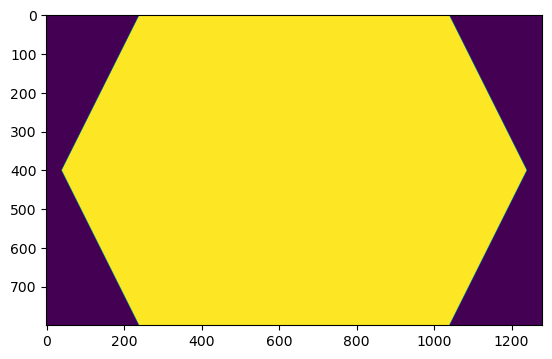

In [80]:
plt.imshow(visible_mask)

In [81]:
empirical_mask = mastermat.simulate_image(np.ones((800, 1280)), mastermat_csr) > 0

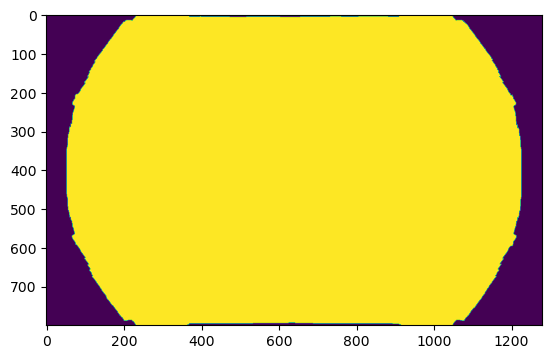

In [82]:
plt.imshow(mastermat.simulate_image(np.ones((800, 1280)), mastermat_csr) > 0)

In [83]:
np.save("../data/fov_indicator.npy", mastermat.simulate_image(np.ones((800, 1280)), mastermat_csr) > 0)

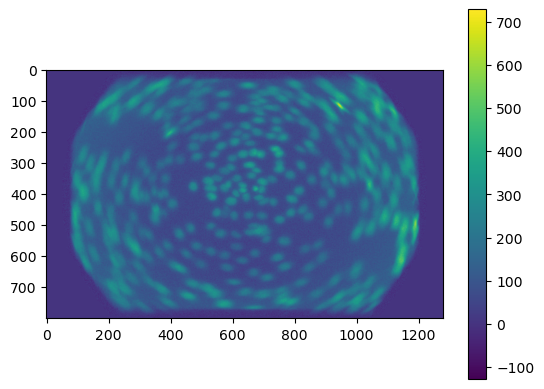

In [84]:
plt.imshow(simmed_noisy*empirical_mask)
# plt.imshow(simmed_noisy)
plt.colorbar()

In [85]:
np.max(simmed_img)

675.9272877234736

In [86]:
np.max(simmed_noisy)

729.64660469804

# Troubleshooting shifting
It was observed, initially, that our MultiWienerNet had learned to shift the image up and to the left. Upon further investigation, it was discovered that:
* The learned PSFs had all been shifted to the bottom right
    * This shift had not been present initially, upon creation of the neural network. It was definitely learned.
* The loss function rewarded the MultiWienerNet's shifting of the image to the top left
* The ground truth, relative to the simulated blurred image, had indeed been shifted up and to the left by about 32 pixels each. Rather, the simulation process shifts the image down and to the right by 32 pixels each.

This last point can directly be observed in this notebook. I want to find out why this is happening.